In [2]:
import os
import sys
import re
import json
import numpy as np
import pandas as pd
from collections import defaultdict


In [70]:
from collections import defaultdict

num_doc = 20000

dataset_names = ['kp20k', 'openkp', 'kptimes', 'stackex']
# dataset_names = ['kp20k', 'openkp']

KP_DATASET_FIELDS = {'kp20k': ('title', 'abstract', 'keywords', None),
                     'stackex': ('title', 'question', 'tags', 'categories'),
                     'openkp': ('url', 'text', 'KeyPhrases', None),
                     'kptimes': ('title', 'abstract', 'keyword', 'categories')}
dataset_split = 'train'
json_base_dir = '/zfs1/hdaqing/rum20/kp/data/kp/json' # path on CRC

dataset_src_lens, dataset_tgt_lens, dataset_tgt_nums  = {}, {}, {}    
dataset_unique_kp_count, dataset_unique_preskp_count, dataset_unique_abskp_count = {}, {}, {}

dataset_examples_dict = {}

for dataset_name in dataset_names:
    src_len, tgt_len, tgt_num = [], [], []
    data_examples = []
    num_present_doc, num_present_tgt = 0, 0
    num_absent_doc, num_absent_tgt = 0, 0
    
    unique_kp_count, unique_preskp_count, unique_abskp_count = defaultdict(int), defaultdict(int), defaultdict(int)
    print(dataset_name)

    input_json_path = os.path.join(json_base_dir, dataset_name, '%s.json' % dataset_split)
    
    with open(input_json_path, 'r') as input_json:
        for ex_id, json_line in enumerate(input_json):
            if ex_id >= num_doc: break
            ex_dict = json.loads(json_line)
            
            title_field, text_field, keyword_field, _ = KP_DATASET_FIELDS[dataset_name]

            src_str = ex_dict[title_field] + ' . ' + ex_dict[text_field]
            if isinstance(ex_dict[keyword_field], str):
                tgt_kps = ex_dict[keyword_field].split(';')
            else:
                tgt_kps = ex_dict[keyword_field]
            data_examples.append({
                'id': ex_id,
                'src': src_str,
                'tgt': tgt_kps
            })

            src_seq = [t for t in re.split(r'\W', src_str) if len(t) > 0]
            tgt_seqs = [[t for t in re.split(r'\W', p) if len(t) > 0] for p in tgt_kps]
#             [kp_set.add(' '.join(p)) for p in tgt_seqs]
            
            for p in tgt_seqs:
                p = ' '.join([w.lower() for w in p])
                unique_kp_count[p] += 1
                                             
            src_len.append(len(src_seq))
            tgt_num.append(len(tgt_seqs))
            tgt_len.extend([len(tgt_seq) for tgt_seq in tgt_seqs])
    
    print('num_doc=', len(src_len))
    print('avg_src_len=', np.mean(src_len))
    print('num_tgt=', sum(tgt_num))
    print('num_unique_tgt=', len(unique_kp_count))
    print('avg_tgt_len=', np.mean(tgt_len))
    
    dataset_examples_dict[dataset_name] = data_examples
    dataset_src_lens[dataset_name] = src_len
    dataset_tgt_lens[dataset_name] = tgt_len
    dataset_tgt_nums[dataset_name] = tgt_num
    dataset_unique_kp_count[dataset_name] = unique_kp_count
    

kp20k
num_doc= 20000
avg_src_len= 160.3073
num_tgt= 106150
num_unique_tgt= 56086
avg_tgt_len= 2.0350635892604805
openkp
num_doc= 20000
avg_src_len= 1118.87665
num_tgt= 46490
num_unique_tgt= 37221
avg_tgt_len= 1.9704022370402237
kptimes
num_doc= 20000
avg_src_len= 800.7895
num_tgt= 101033
num_unique_tgt= 21135
avg_tgt_len= 2.192719210554967
stackex
num_doc= 20000
avg_src_len= 208.24075
num_tgt= 53827
num_unique_tgt= 4847
avg_tgt_len= 1.3337915915804337


In [61]:
dataset_examples_dict['kp20k'][-1]

{'id': 19999,
 'src': 'On the relations between ELECTRE TRI-B and ELECTRE TRI-C and on a new variant of ELECTRE TRI-B . We study the relations between ELECTRE TRI B and ELECTRE TRI C. We propose and motivate a new variant of ELECTRE TRI B. We analyze the limits and merits of this variant',
 'tgt': ['decision with multiple attributes',
  'sorting models',
  'electre tri-b',
  'electre tri-c']}

In [71]:
dataset_unique_kp_count_sorted = {}
for dataset_name in dataset_names:
    unique_kp_count = dataset_unique_kp_count[dataset_name]
    unique_kp_count = sorted(list(unique_kp_count.items()), key=lambda x:x[1], reverse=True)
    dataset_unique_kp_count_sorted[dataset_name] = unique_kp_count
    

In [72]:
for dataset_name in dataset_names:
    print(dataset_name)
    for r in dataset_unique_kp_count_sorted[dataset_name][:10]:
        print(r)

kp20k
('paper', 367)
('performance', 334)
('design', 271)
('systems', 239)
('simulation', 239)
('algorithms', 223)
('algorithm', 216)
('optimization', 180)
('data mining', 167)
('use', 165)
openkp
('dictionary', 328)
('definition', 309)
('recipe', 132)
('error', 86)
('united states', 78)
('recipes', 67)
('difference', 66)
('meaning', 45)
('florida', 41)
('history', 34)
kptimes
('baseball', 899)
('football', 723)
('basketball', 714)
('computers and the internet', 611)
('china', 540)
('nyc', 495)
('terrorism', 474)
('politics and government', 462)
('soccer', 420)
('new york city', 377)
stackex
('c', 1390)
('linux', 1040)
('bash', 768)
('java', 757)
('python', 635)
('javascript', 510)
('shell script', 483)
('debian', 457)
('seo', 448)
('algorithms', 443)


### Set up Transformers

In [25]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
device = torch.device("cuda:3")
print(device)
print(torch.cuda.device_count())

True
Tesla V100-PCIE-32GB
cuda:3
4


In [26]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("roberta-large")
model = AutoModel.from_pretrained("roberta-large").to(device)

In [27]:
# dict_keys(['input_ids', 'attention_mask'])
inputs = tokenizer("Hello world!", return_tensors="pt").to(device)
print(inputs['input_ids'].device)

cuda:3


In [28]:
outputs = model(**inputs)

In [29]:
# last_hidden_state=[B,L,H], pooler_output=[B,H]
print(outputs['last_hidden_state'].device)
print(outputs['last_hidden_state'].shape)

cuda:3
torch.Size([1, 5, 1024])


In [30]:
inputs

{'input_ids': tensor([[    0, 31414,   232,   328,     2]], device='cuda:3'), 'attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:3')}

In [31]:
outputs['pooler_output'].shape

torch.Size([1, 1024])

In [32]:
outputs['pooler_output'].is_cuda

True

### Generate Phrase Embedding

#### Phrase CLS

In [73]:
phrases = []
labels = []

for d_id, d_name in enumerate(['kp20k', 'openkp', 'kptimes', 'stackex']):
#     _phrases = [p for doc in dataset_examples_dict[d_name] for p in doc['tgt']] # take all phrases
    _phrases = [t[0] for t in dataset_unique_kp_count_sorted[d_name][:1000]] # take high-frequency phrases
    _labels = [d_name] * len(_phrases)
    phrases.extend(_phrases)
    labels.extend(_labels)
    print(d_name, len(_phrases))


kp20k 1000
openkp 1000
kptimes 1000
stackex 1000


In [74]:
print(len(phrases))
print(len(labels))

4000
4000


In [75]:
print(phrases[-10:])

['gvim', 'crash', 'framebuffer', 'counting complexity', 'computational physics', 'game development', 'parallel', 'mv', 'route', 'resolution']


In [76]:
inputs = tokenizer(phrases, return_tensors="pt", padding=True).to(device)

In [77]:
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['attention_mask'].shape)

dict_keys(['input_ids', 'attention_mask'])
torch.Size([4000, 14])
torch.Size([4000, 14])


In [78]:
inputs['attention_mask'].cpu().numpy()

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [79]:
batch_size = 16
phrase_batches = [phrases[i: i+batch_size] for i in range(0, len(phrases), batch_size)]

cls_outputs, last_hidden_states = [], []
for b in phrase_batches:
    inputs = tokenizer(b, return_tensors='pt', padding=True).to(device)
    outputs = model(**inputs)
    # last_hidden_state=[B,L,H], pooler_output=
    cls_output = outputs['pooler_output'].detach().cpu().numpy().tolist() # [B,H]
    last_hidden_state = outputs['last_hidden_state'].detach().cpu().numpy().tolist() # [B,L,H]
    
    cls_outputs.extend(cls_output)
    last_hidden_states.extend(last_hidden_state)

print(len(cls_outputs))
print(len(last_hidden_states))

4000
4000


In [80]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd  

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(cls_outputs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.562s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.114854
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.827118
[t-SNE] KL divergence after 1000 iterations: 1.929949


In [81]:
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

np.unique(df["y"], return_counts=True)

(array(['kp20k', 'kptimes', 'openkp', 'stackex'], dtype=object),
 array([1000, 1000, 1000, 1000]))

[Text(0.5, 1.0, 'Visualizing phrases from four domains with T-SNE projection')]

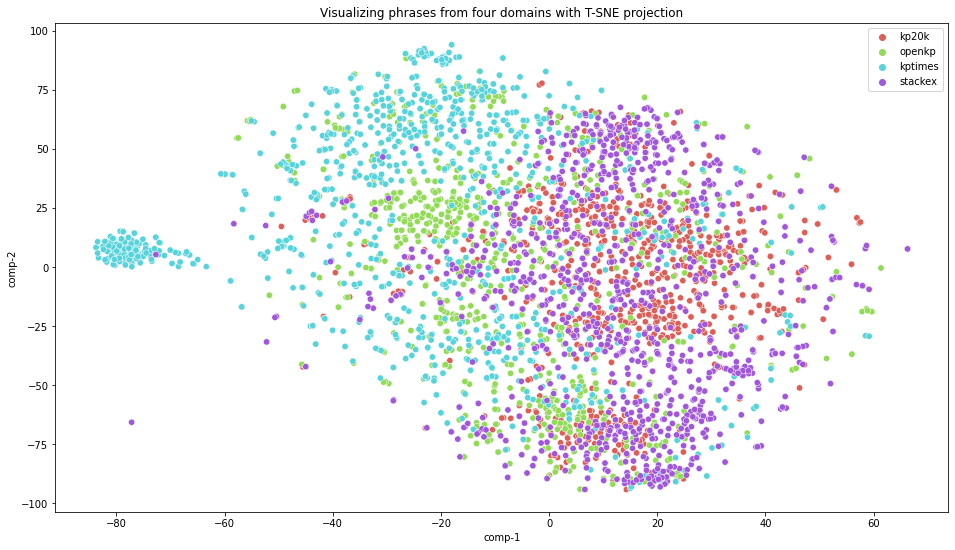

In [115]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[16, 9])
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4), s=40,
                data=df).set(title="Visualizing phrases from four domains with T-SNE projection")


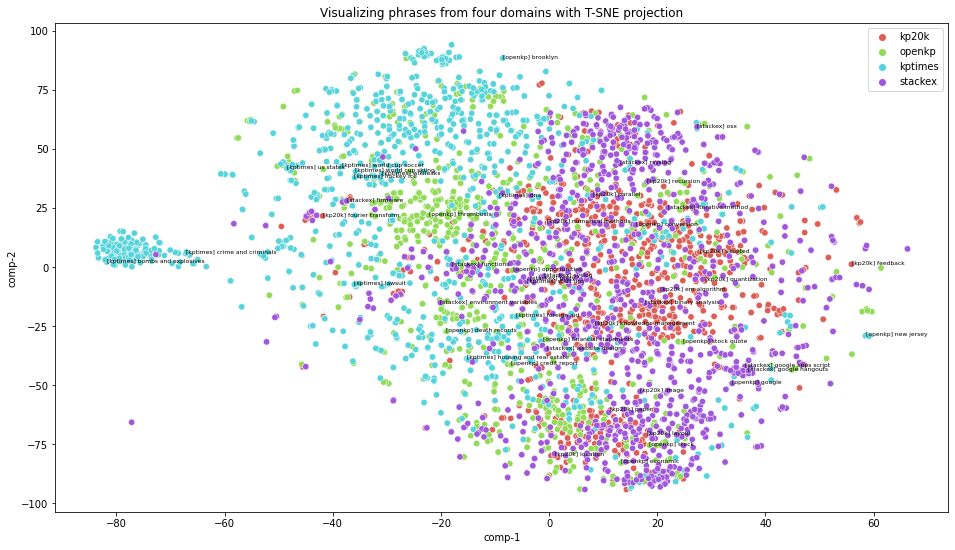

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[16, 9])
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 4), s=40,
                data=df).set(title="Visualizing phrases from four domains with T-SNE projection")

for i, (p, dname) in enumerate(zip(phrases, labels)):
    if i % 83 == 0:
        ax.annotate('[%s] %s' % (dname, p), (z[i][0], z[i][1]), fontsize=6)